# Wordle Solver

### Data: https://www.kaggle.com/datasets/bcruise/wordle-valid-words

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from tqdm import tqdm

np.random.seed(42)
random.seed(42)

df_solutions = pd.read_csv('valid_solutions.csv')

word_list = df_solutions['word'].tolist()
random.shuffle(word_list)

In [2]:
def print_stats(data):
    df = pd.DataFrame(data, columns=['guesses_num'])
    print(df.describe()[1:])
    
def vis_stats(arrays, names, log_x=False, log_y=False, x_range=None, data_type='hist', filename='fig.png'):
    df_compare = pd.DataFrame(
        np.array(
            arrays,
            dtype=np.int32
        ).T,
        columns=[*names]
    )
    plot = None
    if data_type == 'hist':
        plot = sns.displot(df_compare, palette='rocket', binwidth=1, kind=data_type)
    elif data_type == 'ecdf':
        plot = sns.displot(df_compare, palette='rocket', kind=data_type)
    plt.xlabel('Number of guesses')
    if log_x:
        plt.xscale('log')
    if log_y:
        plt.yscale('log')
    if x_range:
        plt.xlim(x_range)
    plt.title('Number of guesses distribution')
    plot.savefig(filename, dpi=600)
    plt.close()

def show_stats(arrays, names, log_x=False, log_y=False, x_range=None):
    _, ax = plt.subplots(1, 2, figsize=(25, 10))
    vis_stats(
        arrays=arrays,
        names=names,
        log_x=log_x,
        log_y=log_y,
        x_range=x_range,
        filename='hist.png'
    )
    vis_stats(
        arrays=arrays,
        names=names,
        log_x=log_x,
        log_y=log_y,
        x_range=x_range,
        filename='ecdf.png',
        data_type='ecdf'
    )
    
    ax[0].imshow(plt.imread('hist.png'))
    ax[0].axis('off')
    ax[1].imshow(plt.imread('ecdf.png'))
    ax[1].axis('off')
    
    plt.show()
    
def performance(name, array):
    guessed_words = array[array <= 6]
    coef = round(100 * len(guessed_words) / len(array), 2)
    space_gap_1 = 6 - len(str(len(guessed_words)))
    space_gap_2 = 2 if len(str(round(np.mean(array), 2))) == 4 else 1
    print(f"{name} performance:")
    print(f"{coef}% - Percentage of words guessed in 6 guesses")
    print(f"{len(guessed_words)}{' ' * space_gap_1} - Number of guessed words")
    print(f"{round(np.mean(array), 2)}{' ' * space_gap_2} - Avarage number guesses ")


# Algorithm Validator

In [3]:
class Algorithm:
    CORRECT_POSITION = 0
    WRONG_POSITION = 1
    NOT_IN_WORD = 2
    
    def __init__(self, word_list):
        self.word_list = word_list

    @staticmethod
    def validate_ans(ans: str, word: str):
        output = [Algorithm.NOT_IN_WORD for _ in range(len(word))]
        new_ans = ''
        new_word = ''
        new_idx = []
        
        for i in range(len(word)):
            if ans[i] == word[i]:
                output[i] = Algorithm.CORRECT_POSITION
            else:
                new_ans += ans[i]
                new_word += word[i]
                new_idx.append(i)
                
        for i in range(len(new_ans)):
            if new_ans[i] in new_word and new_ans[:i].count(new_ans[i]) < new_word.count(new_ans[i]):
                output[new_idx[i]] = Algorithm.WRONG_POSITION
        
        return output
    
    def validate_algorithm(self, show_loop: bool=True, **kwargs):
        guesses_stats = []
        word_list = self.word_list
        
        for word in tqdm(
            word_list,
            desc='Validating algorithm',
            total=len(word_list),
            bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}',
            unit=' guessed words'
            ) if show_loop else word_list:
            
            guesses_num = 0
            answer_list, answer_info = [], []
            possible_words = deepcopy(word_list)
            
            while True:
                guess, possible_words = self.f(
                    answer_list, 
                    answer_info, 
                    possible_words=possible_words, 
                    **kwargs
                    )
                answer_list.append(guess)
                answer_info.append(Algorithm.validate_ans(ans=guess, word=word))
                guesses_num += 1
                if guess == word:
                    guesses_stats.append(guesses_num)
                    break
                
        return guesses_stats

    def f(self, ans, ans_info, possible_words, **kwargs): ...


In [4]:
assert Algorithm.validate_ans(ans='aabaa', word='ababa') == [
    Algorithm.CORRECT_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.NOT_IN_WORD,
    Algorithm.CORRECT_POSITION
    ]
assert Algorithm.validate_ans('aabad', 'ababa') == [
    Algorithm.CORRECT_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.NOT_IN_WORD
    ]
assert Algorithm.validate_ans('ababa', 'ababa') == [
    Algorithm.CORRECT_POSITION,
    Algorithm.CORRECT_POSITION,
    Algorithm.CORRECT_POSITION,
    Algorithm.CORRECT_POSITION,
    Algorithm.CORRECT_POSITION
    ]
assert Algorithm.validate_ans('ababa', 'babab') == [
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.WRONG_POSITION,
    Algorithm.NOT_IN_WORD
    ]
assert Algorithm.validate_ans('bbbbb', 'aaaaa') == [
    Algorithm.NOT_IN_WORD,
    Algorithm.NOT_IN_WORD,
    Algorithm.NOT_IN_WORD,
    Algorithm.NOT_IN_WORD,
    Algorithm.NOT_IN_WORD
    ]

## Random Algorithm (Baseline)

In [5]:
class RA(Algorithm):
    def f(self, ans, ans_info, possible_words, **kwargs):
        possible_words = list(set(possible_words) - set(ans))
        if len(ans) > 0:
            words_with_correct_position = []
            for word in possible_words:
                add_word = True
                for i in range(len(ans[-1])):
                    if ans_info[-1][i] == Algorithm.CORRECT_POSITION and ans[-1][i] != word[i]:
                        add_word = False
                        break
                if add_word:
                    words_with_correct_position.append(word)
            return possible_words[0], words_with_correct_position
        else:
            return possible_words[0], possible_words

In [6]:
ra_stats = np.array(RA(word_list).validate_algorithm()).T

Validating algorithm: 100%|████████████████████| 2315/2315 [00:09<00:00, 245.01 guessed words/s]


In [7]:
arrays, names = [ra_stats], ['ra_guess']
performance('Random Algorithm', ra_stats)

Random Algorithm performance:
10.58% - Percentage of words guessed in 6 guesses
245    - Number of guessed words
12.66  - Avarage number guesses 


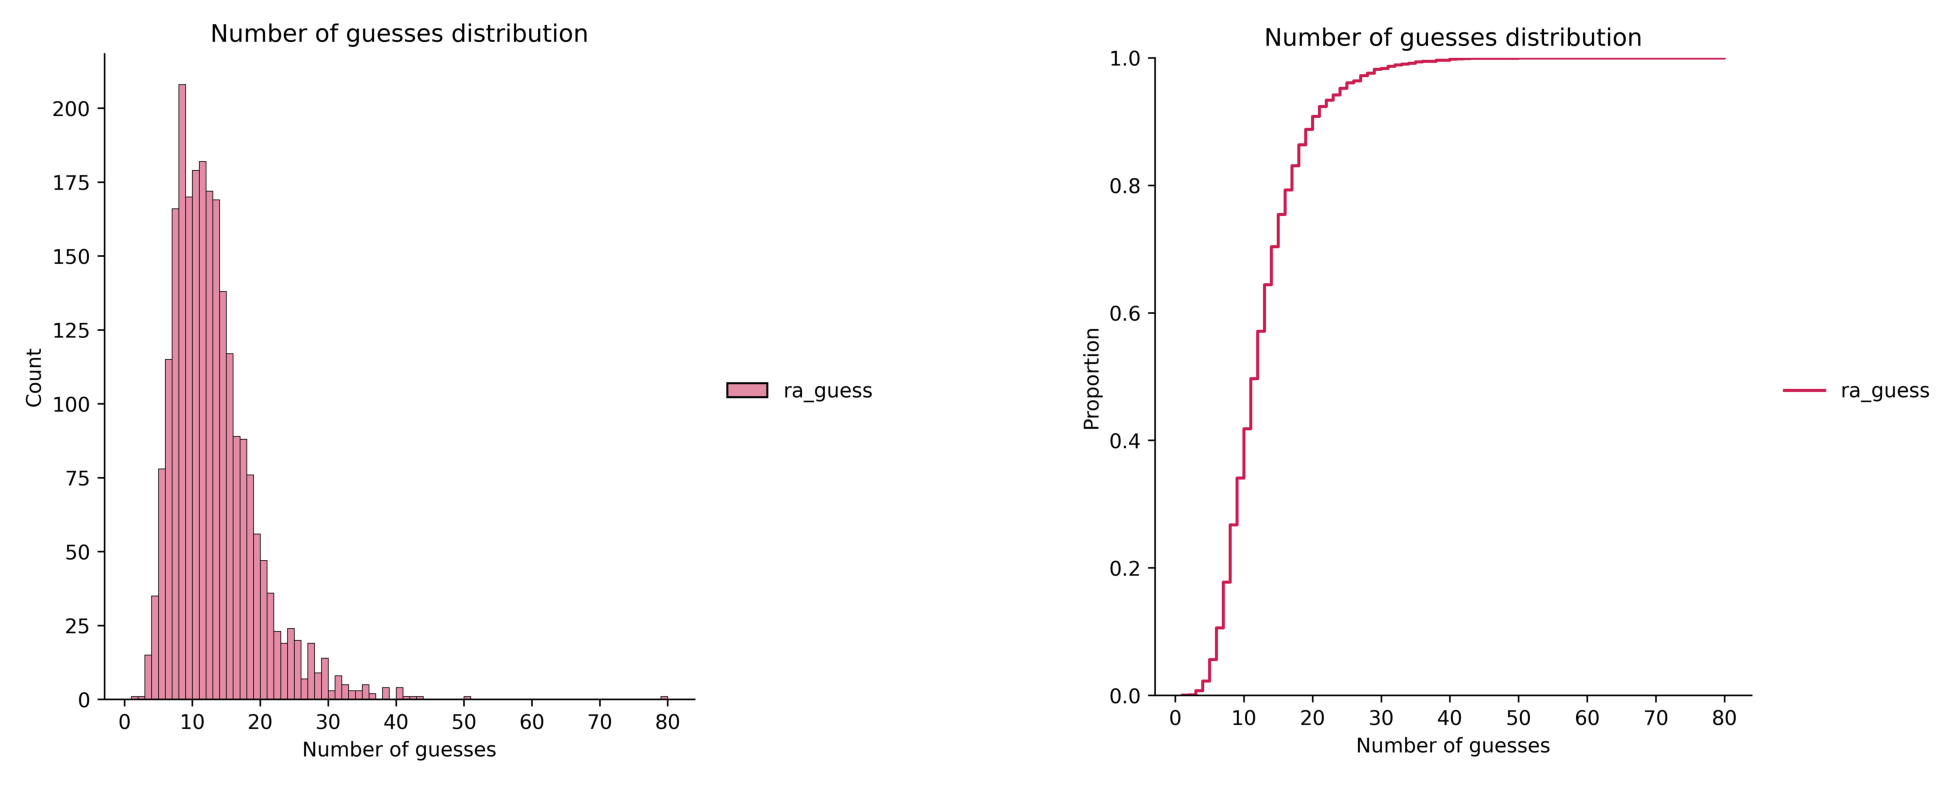

In [8]:
show_stats(arrays, names)

## Random Algorithm with Answer Recudction

In [9]:
class RAAR(Algorithm):
    def f(self, ans, ans_info, possible_words, **kwargs):
        if len(ans) > 0:
            possible_words = [
                word for word in possible_words 
                if Algorithm.validate_ans(ans[-1], word) == ans_info[-1]
            ]
        return possible_words[0], possible_words

In [10]:
raar_stats = np.array(RAAR(word_list).validate_algorithm()).T

Validating algorithm: 100%|████████████████████| 2315/2315 [00:10<00:00, 217.88 guessed words/s]


In [11]:
performance('Random Algorithm with Answer Removal', raar_stats)

Random Algorithm with Answer Removal performance:
98.53% - Percentage of words guessed in 6 guesses
2281   - Number of guessed words
4.03   - Avarage number guesses 


In [12]:
arrays.append(raar_stats)
names.append('raar_guess')

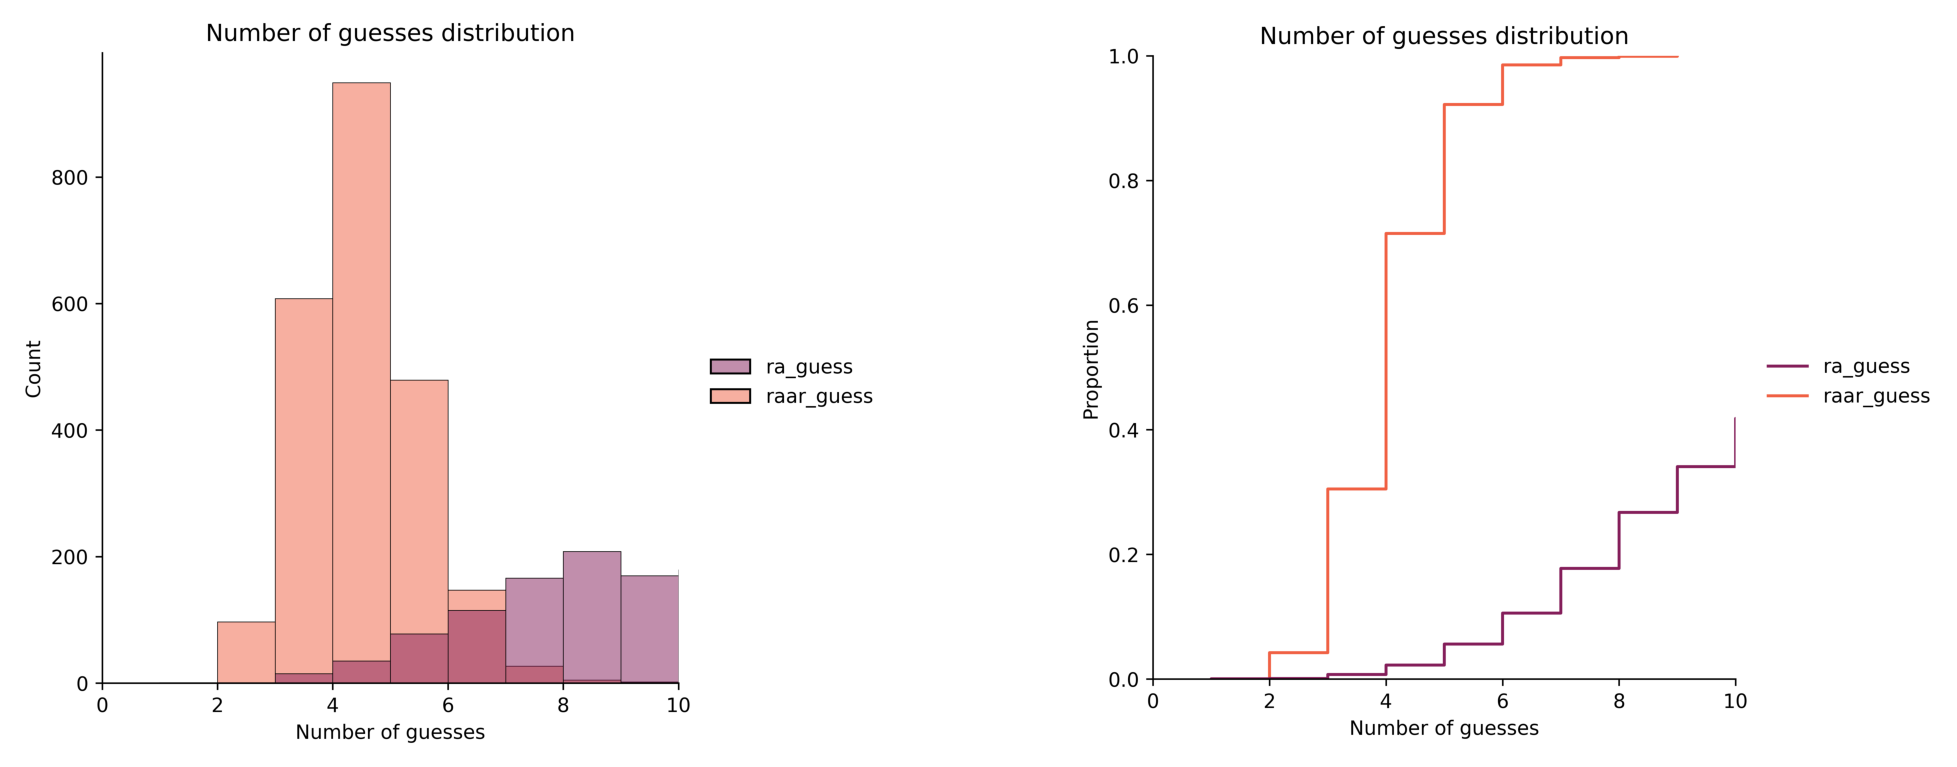

In [13]:
show_stats(arrays, names, x_range=(0, 10))